# Tour of cuml

Machine learning is a fundamental capability of RAPIDS. cuML is a suite of libraries that implements a machine learning algorithms within the RAPIDS data science ecosystem. cuML enables data scientists, researchers, and software engineers to run traditional ML tasks on GPUs without going into the details of CUDA programming.

The cuML repository contains:

python: Python based GPU Dataframe (GDF) machine learning package that takes cuDF dataframes as input. cuML connects the data to C++/CUDA based cuML and ml-prims libraries without ever leaving GPU memory.

cuML: C++/CUDA machine learning algorithms. This library currently includes the following six algorithms; a) Single GPU Truncated Singular Value Decomposition (tSVD), b) Single GPU Principal Component Analysis (PCA), c) Single GPU Density-based Spatial Clustering of Applications with Noise (DBSCAN), d) Single GPU Kalman Filtering, e) Multi-GPU K-Means Clustering, f) Multi-GPU K-Nearest Neighbors (Uses Faiss).

ml-prims: Low level machine learning primitives used in cuML. ml-prims is comprised of the following components; a) Linear Algebra, b) Statistics, c) Basic Matrix Operations, d) Distance Functions, e) Random Number Generation.

Available Algorithms:
Truncated Singular Value Decomposition (tSVD).

Principal Component Analysis (PCA).

Density-based spatial clustering of applications with noise (DBSCAN).

K-Means Clustering.

K-Nearest Neighbors (Requires Faiss installation to use).

Upcoming algorithms:

Kalman Filter.
More ML algorithms in cuML and more ML primitives in ml-prims are being added currently. Example notebooks are provided in the python folder to test the functionality and performance. Goals for future versions include more algorithms and multi-gpu versions of the algorithms and primitives.

## Table of contents
* Dimensionality reduction using PCA
* Clustering
    * k-means
    * DBSCAN
* Similarity searches
    * k-nearest neighbors
    * Truncated SVD

In [1]:
%matplotlib inline
import os

import cudf
import cuml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.cluster
import sklearn.neighbors

## Dimensionality reduction using PCA

In [2]:
home = os.path.expanduser('~')

In [3]:
path = os.path.join(home, 'demo/docker/data/full_apartments_data.csv')
data = pd.read_csv(path)
data.head()

,city,neighborhood,zipcode,price_per_m2,year_built,x,y,population,comprehensive_school,educated,...,small_houses,block_of_flats,labor_force,employed,unemployed,outside_labor_force,children,students,retired_persons,others
0,espoo,tapiola,2100,5444.022222,1985.111111,378711,6672696,4332,604,3003,...,299,2678,2083,1910,173,2085,485,257,1219,124
1,espoo,pohjois-tapiola,2130,3768.000000,1972.857143,377682,6674526,5983,651,3965,...,1414,1355,3033,2819,214,2895,1108,448,1172,167
2,espoo,laajalahti,2140,2770.000000,1977.750000,378239,6675892,3689,522,2190,...,1060,425,1900,1740,160,1810,848,311,550,101
3,espoo,westend,2160,4865.250000,1990.000000,378640,6670467,3194,286,2095,...,908,457,1442,1351,91,1713,622,270,654,167
4,espoo,haukilahti,2170,3860.937500,1972.937500,376534,6671246,5679,663,3865,...,1188,1678,2731,2510,221,2977,951,442,1390,194


In [4]:
neighborhoods = data['neighborhood']
data = data.drop(labels=['neighborhood', 'city', 'x', 'y'], axis=1)

In [5]:
data = data.set_index('zipcode')

In [6]:
print(len(data.columns))

32


In [7]:
data = (data - data.mean()) / data.std()

In [8]:
n_components = 2
whiten = False
random_state = 42
svd_solver = "full"

In [9]:
pca_sk = sklearn.decomposition.PCA(n_components=n_components, svd_solver=svd_solver, 
                                   whiten=whiten, random_state=random_state)
result_sk = pca_sk.fit_transform(data)

In [10]:
pca_sk.explained_variance_ratio_

array([0.61955611, 0.15456241])

In [11]:
# GPU required.
cuml_data = cudf.DataFrame.from_pandas(data)

In [12]:
print(cuml_data)

           price_per_m2           year_built           population comprehensive_school            educated       matriculation          vocational ...              others
2100   1.0904142660260845   0.5158729541840255  -0.8420522016760309  -0.7746147881478422 -0.7117857473760608 -0.5601331874585532 -0.9310043185910691 ... -0.8965710890770592
2130 -0.12562506893884431 -0.07297100056264279 -0.46451880039781157  -0.7336140465761031 -0.3650112755934318 -0.4503020118587892 -0.8142813890960694 ... -0.7032887286878861
2140  -0.8497248095054727  0.16214706815439525  -0.9890867122889291  -0.8461479968474722 -1.0048498279990103 -0.9400410243692123 -1.0952501550947473 ... -0.9999546771921982
2160   0.6704855927212088   0.7508003350951634  -1.1022781318120778   -1.052024060909822 -1.0390947082686046 -0.8626190481267557 -1.2419875521741754 ... -0.7032887286878861
2170 -0.05819418753712986 -0.06910957242947796  -0.5340343388524322  -0.7231457721322548 -0.4010585179824785 -0.4142917903506699 -0.71423

In [13]:
# Note: With this small dataset, the overhead of moving data to the GPU and launching the GPU kernels dominates
# the run time and, thus, there is little benefit from using the GPU.
pca_cuml = cuml.PCA(n_components=n_components, svd_solver=svd_solver, 
                    whiten=whiten, random_state=random_state)
result_cuml = pca_cuml.fit_transform(cuml_data)

In [14]:
# How good is the fit?
print(pca_cuml.explained_variance_ratio_)

                    
0 0.6195561070236225
1 0.1545624063734113


Text(0, 0.5, 'Component 2')

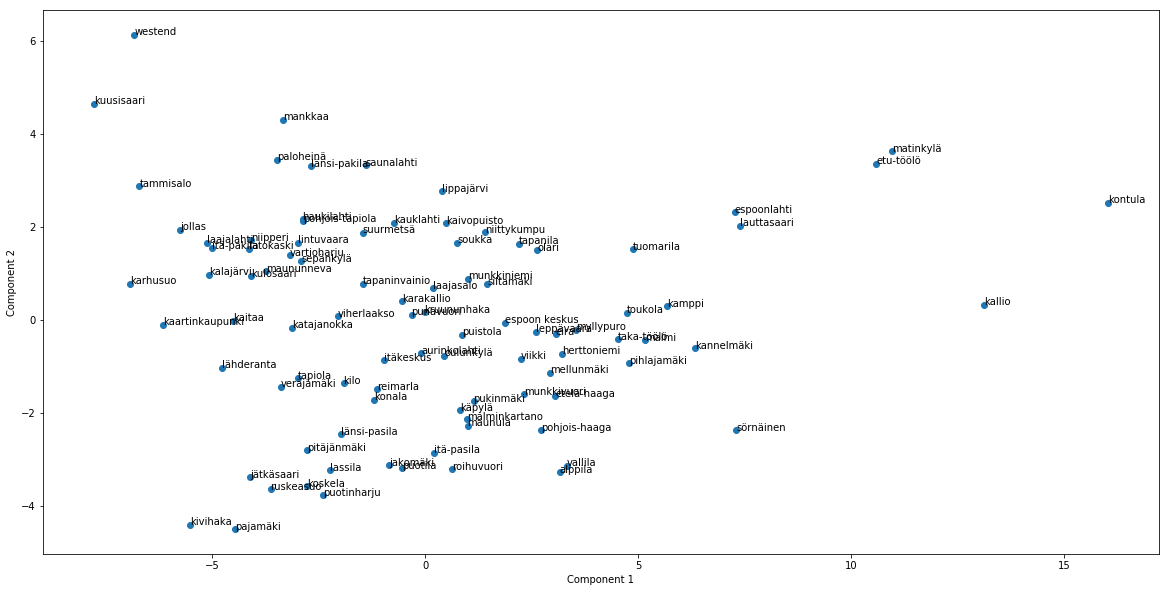

In [15]:
result = result_cuml.to_pandas().values # CPU: use result_sk
index = result_cuml.to_pandas().index # CPU: use data.index
plt.figure(figsize=(20, 10))
plt.plot(result[:, 0], result[:, 1], 'o')

zipcodes = index.values

for i in range(len(zipcodes)):
    plt.text(result_sk[i, 0], result_sk[i, 1], neighborhoods[i])
    
plt.xlabel('Component 1')
plt.ylabel('Component 2')

## k-means clustering

In [16]:
# Note: We pipeline models, i.e, we take the GPU PCA result and feed it to the GPU k-means without going
# through the CPU.
result_cuml

<cudf.DataFrame ncols=2 nrows=93 >

In [17]:
# GPU required.
kmeans = cuml.KMeans(n_clusters=5, n_gpu=-1)
kmeans.fit(result_cuml)
print("labels:")
print(kmeans.labels_)
print("cluster_centers:")
print(kmeans.cluster_centers_)

labels:
       
 0    1
 1    3
 2    3
 3    3
 4    3
 5    3
 6    0
 7    4
 8    2
 9    3
[83 more rows]
cluster_centers:
                    0                     1
0  0.2707176604069329 0.0028047242019252775
1 -2.8474476819868517    -2.808827185648288
2  10.890890497872057    2.3566885760786787
3  -4.369022782584579    2.0134871080639596
4   3.906592359684056   -0.8439355424936809


In [18]:
# sklearn k-means may yield slightly different results due to differences in initialization and other parameters.
#sk_kmeans = sklearn.cluster.KMeans(n_clusters=5)
#sk_kmeans.fit(result_sk)
#result = result_sk

In [19]:
colors = kmeans.labels_.to_pandas().values.astype('float')
#colors = sk_kmeans.labels_.astype('float')

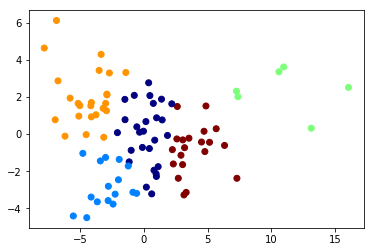

In [20]:
plt.scatter(result[:, 0], result[:, 1], c=colors, cmap="jet")

## Clustering using DBSCAN

In [21]:
path = os.path.join(home, 'demo/docker/data/game_skater_stats.csv')
data = pd.read_csv(path)
data.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,2012030221,8471958,3,1925,0,0,0,3,0,0,...,0,1,0,0,0,5,0,1406,342,177
1,2012030221,8471339,3,1597,1,0,2,3,0,0,...,0,1,3,0,0,2,1,1099,315,183
2,2012030221,8471873,3,1695,0,0,1,2,0,0,...,0,0,0,0,0,2,0,1488,99,108
3,2012030221,8473432,3,957,0,0,3,5,0,0,...,0,0,1,0,0,0,0,957,0,0
4,2012030221,8470192,3,859,0,0,1,0,0,0,...,0,1,0,0,0,2,0,859,0,0


In [22]:
data.isnull().sum()

game_id                 0
player_id               0
team_id                 0
timeOnIce               0
assists                 0
goals                   0
shots                   0
hits                    0
powerPlayGoals          0
powerPlayAssists        0
penaltyMinutes          0
faceOffWins             0
faceoffTaken            0
takeaways               0
giveaways               0
shortHandedGoals        0
shortHandedAssists      0
blocked                 0
plusMinus               0
evenTimeOnIce           0
shortHandedTimeOnIce    0
powerPlayTimeOnIce      0
dtype: int64

In [23]:
len(data)

267854

In [24]:
data = data.drop(['game_id', 'team_id'], axis=1)
data = data.set_index('player_id')

In [25]:
data = data.astype('float')
data = (data - data.mean()) / data.std()

In [26]:
min_samples = 3
eps = 3

In [27]:
%%time
# Not sure how long this takes... Enable at own risk or take a subset of the data.
#clustering_sk = sklearn.cluster.DBSCAN(eps = eps, min_samples = min_samples, n_jobs=-1)
#clustering_sk.fit(data)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [28]:
#np.unique(clustering_sk.labels_)

In [29]:
# GPU required.
cuml_data = cudf.DataFrame.from_pandas(data)

In [30]:
%%time
# GPU required.
clustering_cuml = cuml.DBSCAN(eps = eps, min_samples = min_samples)
clustering_cuml.fit(cuml_data)

CPU times: user 31.7 s, sys: 3.2 s, total: 34.9 s
Wall time: 34.6 s


In [31]:
# How many clusters?
len(clustering_cuml.labels_.unique())

53

In [32]:
# Put labels into the GPU df.
cuml_data['cluster_label'] = clustering_cuml.labels_
cuml_data['player_id'] = cuml_data.index.values

In [33]:
# Let's see how Patrik Laine's games have been clustered.
laine_id = 8479339 # Player ID.
laine_data = cuml_data.query("player_id == @laine_id")
print(laine_data)

             timeOnIce              assists              goals               shots                hits       powerPlayGoals     powerPlayAssists ... player_id
8479339 -0.5348609619264693   1.4201681395403738 -0.376445486045435  0.2066818029181704 -0.8984266364520586 -0.17787727911885567 -0.24146235494694143 ...   8479339
8479339  2.3333573780682424   1.4201681395403738 -0.376445486045435    3.46763484700443  -0.219577778279317 -0.17787727911885567    3.631623316168578 ...   8479339
8479339 0.19157245831000352   1.4201681395403738 -0.376445486045435   4.119825455821682  -0.219577778279317 -0.17787727911885567 -0.24146235494694143 ...   8479339
8479339  0.5360314979526503 -0.48933433694683975 2.1143511450304495  0.8588724117354224 -0.8984266364520586    5.266037337094805 -0.24146235494694143 ...   8479339
8479339 -0.6883328112722029   1.4201681395403738 -0.376445486045435 -1.0976994147163335 0.45927107989342464 -0.17787727911885567 -0.24146235494694143 ...   8479339
8479339  0.4541798449

In [34]:
print(laine_data['cluster_label'])

       
8479339    0
8479339    1
8479339    0
8479339    2
8479339    0
8479339    0
8479339    1
8479339    2
8479339    0
8479339    0
[162 more rows]


In [35]:
# Most Patrik Laine's games are in the 0th cluster but there is some special cases like games with cluster 10.
# Games with cluster 10 seem to contain a lot of goals.
print(laine_data.query("cluster_label == 10"))

           timeOnIce              assists              goals             shots                hits     powerPlayGoals     powerPlayAssists ... player_id
8479339  0.252961198048297 -0.48933433694683975 4.6051477761063335  3.46763484700443  -0.219577778279317 10.709951953308467 -0.24146235494694143 ...   8479339
8479339 0.6451670352651719 -0.48933433694683975 4.6051477761063335 2.163253629369926  -0.219577778279317 10.709951953308467 -0.24146235494694143 ...   8479339
8479339 0.5871887810678947 -0.48933433694683975 4.6051477761063335 4.119825455821682 -0.8984266364520586 10.709951953308467 -0.24146235494694143 ...   8479339
[13 more columns]


## Similarity searches

## k-nearest neighbors

The following examples are inspired by: https://beckernick.github.io/music_recommender/ and https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c

In [36]:
path = os.path.join(home, 'demo/docker/data/')

In [37]:
# The initial data handling is copied from https://beckernick.github.io/music_recommender/, the rest of the
# analysis is our own but inspired by the above blog posts.
user_data = pd.read_table(os.path.join(path, 'usersha1-artmbid-artname-plays.tsv'),
                          header=None, nrows=2e7,
                          names=['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols=['users', 'artist-name', 'plays'])
user_data.head()

,users,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


In [38]:
user_profiles = pd.read_table(os.path.join(path, 'usersha1-profile.tsv'),
                              header=None,
                              names=['users', 'gender', 'age', 'country', 'signup'],
                              usecols=['users', 'country'])
user_profiles.head()

,users,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,United States


In [39]:
user_data = user_data.dropna(axis=0, subset=['artist-name'])

In [40]:
artist_plays = (user_data.
     groupby(by = ['artist-name'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_artist_plays'})
     [['artist-name', 'total_artist_plays']]
    )
artist_plays.head()

,artist-name,total_artist_plays
0,04)],6
1,2,1606
2,58725ab=>,23
3,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,70
4,amy winehouse,23


In [41]:
user_data_with_artist_plays = user_data.merge(artist_plays,
                                              left_on='artist-name',
                                              right_on='artist-name',
                                              how='left')

In [42]:
# Note: The blog posts reduce the amount of data heavily due to computational constraints. Here, we use more
# data as we can tap into the GPU.
popularity_threshold = 5000
user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
user_data_popular_artists.head()

,users,artist-name,plays,total_artist_plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137,25651
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,3704875
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,180391
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,410725
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,90498


In [43]:
combined = user_data_popular_artists.merge(user_profiles,
                                           left_on='users',
                                           right_on='users',
                                           how='left')
finland_data = combined[combined["country"] == "Finland"]
finland_data.head()

,users,artist-name,plays,total_artist_plays,country
277,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,stam1na,758,791472,Finland
278,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,dream theater,572,5892595,Finland
279,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,ac/dc,554,6098979,Finland
280,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,metallica,473,15481852,Finland
281,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,iron maiden,471,9496576,Finland


In [44]:
finland_data = finland_data.drop_duplicates(['users', 'artist-name'])

In [45]:
%%time
X = finland_data.pivot_table(index='artist-name',
                             columns='users',
                             values='plays').fillna(0)

CPU times: user 4.73 s, sys: 732 ms, total: 5.46 s
Wall time: 4.13 s


In [46]:
# Format the data to be suitable for cudf.
X = X.reset_index()
X = X.drop('artist-name', axis=1)

In [47]:
X.shape

(20634, 11564)

In [48]:
X = X.astype("float32")

In [49]:
%%time
# Expensive but CPU training below is even more expensive. GPU required.
cuml_X = cudf.DataFrame.from_pandas(X)

CPU times: user 39.6 s, sys: 3.23 s, total: 42.9 s
Wall time: 43.2 s


In [50]:
n_neighbors = 10

In [51]:
%%time
# GPU required.
cuml_knn = cuml.KNN(n_gpus=1)
cuml_knn.fit(cuml_X)
cuml_D, cuml_I = cuml_knn.query(cuml_X, n_neighbors)

CPU times: user 6.92 s, sys: 860 ms, total: 7.78 s
Wall time: 7.78 s


In [52]:
%%time
# Didn't finish in 1 hour on a 12-core CPU.
# sk_knn = sklearn.neighbors.NearestNeighbors(n_neighbors).fit(X)
# sk_D, sk_I = sk_knn.kneighbors(X, n_neighbors)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.58 µs


In [53]:
#sk_I

In [54]:
cuml_I.to_pandas()

,index_neighbor_0,index_neighbor_1,index_neighbor_2,index_neighbor_3,index_neighbor_4,index_neighbor_5,index_neighbor_6,index_neighbor_7,index_neighbor_8,index_neighbor_9
0,0,19168,12052,2109,2844,19897,15370,112,2025,12451
1,1,11218,18651,5136,1962,13385,15076,1043,10887,9884
2,2,7948,19219,19086,11056,18627,17807,13977,12990,6093
3,3,1043,1289,1419,3464,2698,3078,11138,9884,10887
4,4,8966,2451,3371,4013,6363,11780,1483,16498,1383
5,5,3013,2979,11624,3093,14292,8728,2988,3229,12201
6,6,2786,11302,1289,3464,2698,3078,1043,9884,10887
7,7,6486,3043,12831,2797,5525,11417,18959,332,8841
8,8,17206,1289,1043,3464,2698,3078,1419,9884,10887
9,9,3672,2672,18865,3004,2698,3464,1043,9884,10887


In [55]:
# Free GPU memory.
for v in list(locals().keys()):
    if 'cuml_' in v or '_cuml' in v:
        del locals()[v]

## Truncated singular value decomposition (TSVD)

In [56]:
path = os.path.join(home, 'demo/docker/data/')

In [57]:
user_data = pd.read_table(os.path.join(path, 'usersha1-artmbid-artname-plays.tsv'),
                          header=None, nrows=2e7,
                          names=['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols=['users', 'artist-name', 'plays'])
user_data.head()

,users,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


In [58]:
user_profiles = pd.read_table(os.path.join(path, 'usersha1-profile.tsv'),
                              header=None,
                              names=['users', 'gender', 'age', 'country', 'signup'],
                              usecols=['users', 'country'])
user_profiles.head()

,users,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,United States


In [59]:
user_data = user_data.dropna(axis=0, subset=['artist-name'])

In [60]:
artist_plays = (user_data.
     groupby(by = ['artist-name'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_artist_plays'})
     [['artist-name', 'total_artist_plays']]
    )
artist_plays.head()

,artist-name,total_artist_plays
0,04)],6
1,2,1606
2,58725ab=>,23
3,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,70
4,amy winehouse,23


In [61]:
user_data_with_artist_plays = user_data.merge(artist_plays,
                                              left_on='artist-name',
                                              right_on='artist-name',
                                              how='left')

In [62]:
popularity_threshold = 500000
user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
user_data_popular_artists.head()

,users,artist-name,plays,total_artist_plays
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,3704875
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,13547741
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507,1004743
10,00000c289a1829a808ac09c00daf10bc3c4e223b,walls of jericho,393,620899
12,00000c289a1829a808ac09c00daf10bc3c4e223b,goldfrapp,361,2577285


In [63]:
combined = user_data_popular_artists.merge(user_profiles,
                                           left_on='users',
                                           right_on='users',
                                           how='left')

In [64]:
combined = combined.drop_duplicates(['users', 'artist-name'])

In [65]:
%%time
X = combined.pivot_table(index='users', columns='artist-name', values='plays').fillna(0)

CPU times: user 18.3 s, sys: 2.88 s, total: 21.2 s
Wall time: 18.2 s


In [66]:
X.head()

artist-name,+44,...and you will know us by the trail of dead,16 horsepower,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,3oh!3,50 cent,...,Сплин,ガゼット,ムック,久石譲,宇多田ヒカル,梶浦由記,植松伸夫,浜崎あゆみ,菅野よう子,동방신기
users,,,,,,,,,,,,,,,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00001411dc427966b17297bf4d69e7e193135d89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00004d2ac9316e22dc007ab2243d6fcb239e707d,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00007a47085b9aab8af55f52ec8846ac479ac4fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Format for cudf.
X = X.reset_index()
X = X.drop('users', axis=1)

In [68]:
X.shape

(356741, 1285)

In [69]:
n_components = 40
random_state = 42

In [70]:
%%time
algorithm = 'arpack'
sk_tsvd = sklearn.decomposition.TruncatedSVD(n_components=n_components,
                                             algorithm=algorithm, 
                                             random_state=random_state)
sk_result = sk_tsvd.fit_transform(X)

CPU times: user 2min 45s, sys: 1.92 s, total: 2min 46s
Wall time: 28.3 s


In [71]:
%%time
# The time to move data to the GPU + computing the TSVD is lower than that of computing the TSVD on the CPU.
# GPU required.
cuml_X = cudf.DataFrame.from_pandas(X)

CPU times: user 5.78 s, sys: 1.66 s, total: 7.44 s
Wall time: 7.56 s


In [72]:
%%time
# GPU required.
algorithm = 'full'
cuml_tsvd = cuml.TruncatedSVD(n_components=n_components,
                              algorithm=algorithm, 
                              random_state=random_state)
cuml_result = cuml_tsvd.fit_transform(cuml_X)

CPU times: user 4.37 s, sys: 276 ms, total: 4.64 s
Wall time: 4.64 s


In [73]:
cuml_result.to_pandas()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,25.484256,190.556608,-31.338465,-15.281125,-45.671815,-5.856145,6.885757,-67.207197,33.708774,19.864555,...,18.908646,2.617127,-25.639946,-140.907299,-138.664991,-101.156227,83.021828,-60.092995,174.518318,16.115740
1,136.531465,1683.418578,-245.665873,-706.399956,-113.498056,-15.900123,-17.033764,633.092502,-698.810449,1206.443617,...,119.943753,27.056856,1150.207759,402.881649,-240.484972,282.666337,-11.156897,-1598.418982,413.945688,-71.406816
2,0.847519,13.238973,0.447347,-3.803376,0.409061,-0.157565,-1.905522,0.135612,-8.502080,-4.277642,...,3.126801,2.241860,21.314967,-8.181559,16.993917,2.947127,9.914219,-4.323199,2.386330,2.616657
3,0.774074,8.552813,-2.787724,5.090695,-2.393326,-0.638501,0.677728,-10.803769,5.212503,-0.490907,...,-0.239463,-0.025838,3.569100,0.399720,2.237289,1.984111,-3.765371,1.062166,-4.699627,9.414097
4,7.409898,103.713331,-15.019988,-47.338064,-8.188895,-0.580236,-12.552942,45.456363,-89.877750,57.267064,...,18.248195,11.618561,80.990458,-15.497598,21.382244,-5.109917,15.604298,-59.106464,29.079635,22.248695
5,105.730569,1557.161201,-305.962548,-736.052351,-218.394935,6.163846,-167.804834,852.814889,-960.758184,908.356908,...,-26.392069,-23.784510,-70.650686,-5.380971,147.839625,-216.426469,-82.874996,1.231659,-137.057685,140.238067
6,29.349910,274.144686,-83.792972,131.760430,-92.864841,-20.080335,29.475516,-379.396561,299.740749,70.651411,...,-0.383982,2.354587,-2.417050,172.204439,2.921642,116.451911,-8.540848,-45.587263,-54.867679,26.263262
7,3.198312,36.748252,25.376836,9.704492,-8.451919,-1.218361,-2.712137,-31.168713,15.768606,-1.285726,...,0.380364,2.389711,11.452508,3.563717,0.498055,7.156311,-6.503403,-5.383621,-0.662745,-13.626061
8,0.067702,1.186290,1.295021,0.007708,-0.190129,-0.174863,1.653260,0.010459,0.038666,0.359853,...,-0.121605,-0.178907,-0.324101,0.524534,-0.726809,-0.414440,-0.419759,-0.019525,-0.000276,0.198532
9,71.061732,256.103567,-48.734459,10.349713,-81.659392,-20.028944,53.286094,-194.765781,-1.964136,47.967224,...,-30.107370,-63.556273,-431.644919,51.788518,128.044258,38.745012,197.894843,111.665653,-266.072087,-94.960629
